# Creating our own Auto Differentiation (AutoGrad) framework

In this practical exercise we will build our own, very simple, Auto-differentiation (or AutoGrad) framework.

## Coding the framework

### Step 1: Define a class for our variables

The key idea is that we will define our own class of `Variable` which is basically the same as a scalar (a number). So our class is created by passing it a `value`, and it stores this value internally.

But apart from being a placeholder for a number, we also want to keep track of the way every variable was created.

For example, if a variable $c$ is the result of the addition of two variables $a$ and $b$: $c = a + b$, then we would say that $a$ and $b$ are "parent" variables of $c$, and $c$ is their "child". The way $c$ was created was by adding these two parent variables together.

So apart from the value of the variable, we will also have to keep track of the parents, and on how each of them "contributes" to the creation of the variable - this is described by the local derivative associated with each of the parents, that tells us how a change in each of the parent variables translates into a change in the child variable.

This is important in order to implement our backwards pass. Each parent defines a "route" through which the gradients coming into this variable will have to flow through. So we will define a list of `gradRoutes` that will contain the list of parent variables and their corresponding local derivatives. A variable created directly (not resulting by any operation over existing variables) will have an empty `gradRoutes`.

Finally, we want each variable of ours to keep also the value of gradient of the quantity we are interested in with respect to that variable. We will create a placeholder for that as well, called `grad`. As seen before, this will accummulate the gradients that are backpropagated from the children of this variable when we implement the backpropagation algorithm. So we will initialise it to zero.

In [2]:
import numpy as np

In [3]:
class Variable: #Simple variable. These are the leafs of our tree, they can request to have a gradient calculated, or not
    def __init__(self, value):
        self.value = value
        self.gradRoutes = [] # A variable by default has no grad Routes (was not created by anything, just defined)
        self.grad = 0.0        
        
    def __str__(self):
        return 'Value: {self.value}'.format(self=self)        

Apart from the `__init__()` function which stores the value passed to our class and initialises the `gradRoutes` and `grad` member variables, we have also overloaded the function that python uses to convert a class into a string representation: `__str__()`. This will allow us to print our class.

We cannot do much yet with this class, apart from storing values into our variables and printing them out. Let's try this out. 

In [4]:
a = Variable(4.3)
b = Variable(5.2)
print(a)
print(b)

Value: 4.3
Value: 5.2


### Step 2: Define operations over our variables

The next step would be to implement operations on our variables. Let's first define the operations for addition and multiplication.

These will be functions that take two variables as input and produce a new (child) variable with a value equal to the sum or the product of the two inputs. Apart from the forward pass though, we should keep track of how this new variable was created: the two parent variables, and their corresponding local derivatives.

In [5]:
def vAdd(A: Variable, B: Variable): # Addition
    result = Variable(A.value + B.value) # Create a new Variable to store the result, and pass it the value = a + b
          
    #keep track of the parent variables, and of the local derivative associated with each one
    result.gradRoutes.append((A, 1)) # dresult / dA = 1
    result.gradRoutes.append((B, 1)) # dresult / dB = 1
    
    return result
    
def vMul(A: Variable, B: Variable): # Addition
    result = Variable(A.value * B.value) # Create a new Variable to store the result, and pass it the value = a + b
          
    #keep track of the parent variables, and of the local derivative associated with each one
    result.gradRoutes.append((A, B.value)) # dresult / dA = B
    result.gradRoutes.append((B, A.value)) # dresult / dB = A
    
    return result

So for example to calculate $d = (a + b) * c$ we first need to calculate $(a + b)$ and then mutiply the result with $c$

In [6]:
a = Variable(2) # a = 2
b = Variable(3) # b = 3
c = Variable(4) # c = 4

#d = (a + b) * c = 20
d = vMul(vAdd(a, b), c)

print(d)

Value: 20


### Step 3: Implement the backpropagation function

The final step is to implement the backpropagation function. This starts with a child variable, and backpropagates gradients through the routes defined recursively. It uses the two rules that we saw before:

- Accumulate the incoming gradients from the different grad routes that lead to a node (a variable). Each of the incoming gradients describe a different way in which the node affects the quantity of interest, so this sum will be the final gradient for the node
- Multiply every incoming gradient with each of the local derivatives corresponding to parent variables (this would be the application of the chain rule), and continue the backpropagation through the corresponding route (for each of the parent variables)

We update the `Variable` class accordingly. We also update the `__str___()` function to include also gradient information.

In [7]:
class Variable: #Simple variable. These are the leafs of our tree, they can request to have a gradient calculated, or not
    def __init__(self, value):
        self.value = value
        self.gradRoutes = [] # A variable by default has no grad Routes (was not created by anything, just defined)
        self.grad = 0.0
    
    def backProp(self, route_val=1.0):
        # Add together the incoming gradients from the different routes that lead to a node - this will be the final gradient for the node
        self.grad += route_val
                
        # For every parent variable and corresponding local derivative value that we have in the gradRoutes, continue with the gradient calculation
        for variable, local_derivative_value in self.gradRoutes:
            # Multiply the incoming gradient with the local derivatives corresponding the parent variable, and continue the backpropagation
            variable.backProp(local_derivative_value * route_val)
    
    def __str__(self):
        return 'Value: {self.value}, Gradient: {self.grad}'.format(self=self)

<font color=blue>**Question:** Why did we set the default value of route_val equal to 1.0?</font>

---

*Answer*


---


This should be all. If we want to calculate the derivative of the result with respect to any of the variables that participated in the calculation, we just need to call backprop on the result, and then read the derivatives out.

In [8]:
a = Variable(2)           # a = 2
b = Variable(3)           # b = 3
c = Variable(4)           # c = 4
res = vMul(vAdd(a, b), c) # res = (a + b) * c = 20

print("Result =", res.value)

# Call backprop on the result
res.backProp()

# Now all variables should contain in their "grad" the derivative d(res) / d(variable)
print("The derivative of the result with respect to a is:", a.grad)
print("The derivative of the result with respect to b is:", b.grad)
print("The derivative of the result with respect to c is:", c.grad)

Result = 20
The derivative of the result with respect to a is: 4.0
The derivative of the result with respect to b is: 4.0
The derivative of the result with respect to c is: 5.0


In the following example, variable $a$ affects the result through two different routes

In [9]:
a = Variable(4)  # a = 4
b = Variable(3)  # b = 3
c = vAdd(a, b)   # c = 4 + 3
res = vMul(a, c) # res = a * c = 28

print("Result =", res.value)

# Call backprop on the result
res.backProp()

# Now all variables should contain in their "grad" the derivative d(res) / d(variable)
print("The derivative of the result with respect to a is:", a.grad)
print("The derivative of the result with respect to b is:", b.grad)
# Also for intermediate results
print("The derivative of the result with respect to c is:", c.grad)

Result = 28
The derivative of the result with respect to a is: 11.0
The derivative of the result with respect to b is: 4.0
The derivative of the result with respect to c is: 4.0


<font color=blue>**Question:** Can you now use this setup to calculate the derivative of $c$ with respect to $a$ and $b$?</font>

In [10]:
# Your Code Here


## Final touches

If you understood how this works up to here, then you should be already good to go. But since we want to use our auto grad to do some practical work, we will continue working on it a bit, to make it a bit more usable and complete it with more operations. Many of the subsequent steps are quite "engineering" in nature.

### Improving usability: overloading operators

Of course this is still highly incomplete, very inefficient and not very usable. Lets first improve a usability issue. Instead of having to call different functions for the operations like `res = vMul(a, c)`, we would like to be able to directly write them down like `res = a * b`. To achieve this, we should overload [Python's special functions for operator overloading](https://docs.python.org/3/reference/datamodel.html#emulating-numeric-types).

Here's how to do this for the addition and multiplication.

In [11]:
class Variable: #Simple variable. These are the leafs of our tree, they can request to have a gradient calculated, or not
    def __init__(self, value):
        self.value = value
        self.gradRoutes = [] # A variable by default has no grad Routes (was not created by anything, just defined)
        self.grad = 0.0
    
    def backProp(self, route_val = 1.0):
        # Add together the incoming gradients from the different routes that lead to a node - this will be the final gradient for the node
        self.grad += route_val
                
        # For every parent variable and corresponding local derivative value that we have in the gradRoutes, continue with the gradient calculation
        for variable, local_derivative_value in self.gradRoutes:
            # Multiply the incoming gradient with the local derivatives corresponding the parent variable, and continue the backpropagation
            variable.backProp(local_derivative_value * route_val)
            
    def __add__(self, b):
        return vAdd(self, b)
        
    def __mul__(self, b):
        return vMul(self, b)            
    
    def __str__(self):
        return 'Value: {self.value}, Gradient: {self.grad}'.format(self=self)

In [12]:
a = Variable(4)  # a = 4
b = Variable(3)  # b = 3
c = a + b        # c = 4 + 3
res = a * c      # res = a * c = 28

print("Result =", res.value)

# Call backprop on the result
res.backProp()

# Now all variables should contain in their "grad" the derivative d(res) / d(variable)
print("The derivative of the result with respect to a is:", a.grad)
print("The derivative of the result with respect to b is:", b.grad)
# Also for intermediate results
print("The derivative of the result with respect to c is:", b.grad)

Result = 28
The derivative of the result with respect to a is: 11.0
The derivative of the result with respect to b is: 4.0
The derivative of the result with respect to c is: 4.0


### Zeroing gradients

A last thing to note is that once we call `backProp`, our gradients are calculated and our variables are now "dirty" in the sense that if we call backprop again, the new result will be added to the previous one:

In [13]:
a = Variable(4)   # a = 4
b = Variable(3)   # b = 3
res = (a + b) * a # res = a * c = 28

# Call backprop on the result
res.backProp()
print("The derivative of the result with respect to a is:", a.grad)
print("The derivative of the result with respect to b is:", b.grad)

# Call backprop on the result once more
print("Second time")
res.backProp()
print("The derivative of the result with respect to a is:", a.grad)
print("The derivative of the result with respect to b is:", b.grad)

The derivative of the result with respect to a is: 11.0
The derivative of the result with respect to b is: 4.0
Second time
The derivative of the result with respect to a is: 22.0
The derivative of the result with respect to b is: 8.0


This will actually turn out to be quite useful, e.g. when we want to accumulate weight gradients over different samples in our learning loops (see next), but we need a way to control it.

To avoid this, we should reset the gradients to zero before we call `backProp` again. We can do it one by one for every variable, but we will also implement a function that does this recursively from the child node we backProped from all the way to the parents.

In [14]:
class Variable: #Simple variable. These are the leafs of our tree, they can request to have a gradient calculated, or not
    def __init__(self, value):
        self.value = value
        self.gradRoutes = [] # A variable by default has no grad Routes (was not created by anything, just defined)
        self.grad = 0.0
    
    def backProp(self, route_val = 1.0):
        # Add together the incoming gradients from the different routes that lead to a node - this will be the final gradient for the node
        self.grad += route_val
        print('self.grad',self.grad)
                
        # For every parent variable and corresponding local derivative value that we have in the gradRoutes, continue with the gradient calculation
        for variable, local_derivative_value in self.gradRoutes:
            # Multiply the incoming gradient with the local derivatives corresponding the parent variable, and continue the backpropagation
            print(local_derivative_value, route_val)
            variable.backProp(local_derivative_value * route_val)

    def zeroGrad(self):
        self.grad = 0.0
        
    def zeroGradsRecursively(self):
        self.zeroGrad()
        for variable, _ in self.gradRoutes:
            variable.zeroGradsRecursively()
            
    def __add__(self, b):
        return vAdd(self, b)
        
    def __mul__(self, b):
        return vMul(self, b)           
    
    def __str__(self):
        return 'Value: {self.value}, Gradient: {self.grad}'.format(self=self)

In [15]:
a = Variable(4)   # a = 4
b = Variable(3)   # b = 3
res = (a + b) * a # res = a * c = 28

# Call backprop on the result
res.backProp()
print("The derivative of the result with respect to a is:", a.grad)
print("The derivative of the result with respect to b is:", b.grad)

# Zero gradients
res.zeroGradsRecursively()

# Call backprop on the result once more
print("Second time")
res.backProp()
print("The derivative of the result with respect to a is:", a.grad)
print("The derivative of the result with respect to b is:", b.grad)

self.grad 1.0
4 1.0
self.grad 4.0
1 4.0
self.grad 4.0
1 4.0
self.grad 4.0
7 1.0
self.grad 11.0
The derivative of the result with respect to a is: 11.0
The derivative of the result with respect to b is: 4.0
Second time
self.grad 1.0
4 1.0
self.grad 4.0
1 4.0
self.grad 4.0
1 4.0
self.grad 4.0
7 1.0
self.grad 11.0
The derivative of the result with respect to a is: 11.0
The derivative of the result with respect to b is: 4.0


## More Improvements - Homework

There are number of ways we can improve our simple network. The most important is probably being able to work with vectors and matrices - we will look into this in the next notebook. Before that, there are still a lot of things to do.

---
### <font color=blue>Excercise 1:</font>
    
<font color=blue>We usually do not require gradients for all our variables. If we could indicate which variables require gradients, then we could only keep track of the routes that lead to these variables only and drop all the rest. This would be a huge improvement in resources and speed (number of calculations). Can you add this functionality?</font>

In [16]:
# Your Code Here
class Variable: #Simple variable. These are the leafs of our tree, they can request to have a gradient calculated, or not
    def __init__(self, value, requiresGrad=True):
        self.value = value
        self.gradRoutes = [] # A variable by default has no grad Routes (was not created by anything, just defined)
        self.grad = 0.0
        self.requiresGrad = requiresGrad
    
    def backProp(self, route_val = 1.0):
        # Add together the incoming gradients from the different routes that lead to a node - this will be the final gradient for the node
        self.grad += route_val
                
        # For every parent variable and corresponding local derivative value that we have in the gradRoutes, continue with the gradient calculation
        for variable, local_derivative_value in self.gradRoutes:
              if variable.requiresGrad == True:
                # Multiply the incoming gradient with the local derivatives corresponding the parent variable, and continue the backpropagation
                variable.backProp(local_derivative_value * route_val)

    def zeroGrad(self):
        self.grad = 0.0
        
    def zeroGradsRecursively(self):
        self.zeroGrad()
        for variable, _ in self.gradRoutes:
            variable.zeroGradsRecursively()
            
    def __add__(self, b):
        return vAdd(self, b)

    def __sub__(self, b):
        return vSub(self, b)
        
    def __mul__(self, b):
        return vMul(self, b)    

    def __div__(self, b):
        return vDiv(self, b)       
    
    def __str__(self):
        return 'Value: {self.value}, Gradient: {self.grad}'.format(self=self)

In [17]:
a = Variable(4, requiresGrad = True)   # a = 4
b = Variable(3, requiresGrad = False)   # b = 3
res = (a + b) * a # res = a * c = 28

# Call backprop on the result
res.backProp()
print("The derivative of the result with respect to a is:", a.grad)
print("The derivative of the result with respect to b is:", b.grad)


a.requiresGrad = False
b.requiresGrad = True

# Zero gradients
res.zeroGradsRecursively()

# Call backprop on the result once more
print("Second time")
res.backProp()
print("The derivative of the result with respect to a is:", a.grad)
print("The derivative of the result with respect to b is:", b.grad)

The derivative of the result with respect to a is: 11.0
The derivative of the result with respect to b is: 0.0
Second time
The derivative of the result with respect to a is: 0.0
The derivative of the result with respect to b is: 4.0


## Polynomial Regression

We will use our AutoGrad framework to implement polynomial regression. First, let's create some noisy training data for the function $y = w_0 + w_1*x + w_2*x^2$ for some values of the weights $w$ ($w_0$ is the bias term). We will then try to estimate these values from the data.

In [18]:
m = 100 # number of training points
w = [-1.0, 2.0, 1.0] # These are the true values for our weights that we will then try to estimate from the data

XX = 4 * np.random.rand(m) - 2 # Randomly select m points in the range [-2, 2]
YY = w[0] + w[1] * XX + w[2] * (XX**2) # calculate the true outputs
YY += np.random.normal(scale = 0.3, size = YY.size) # add noise to simulate observation error

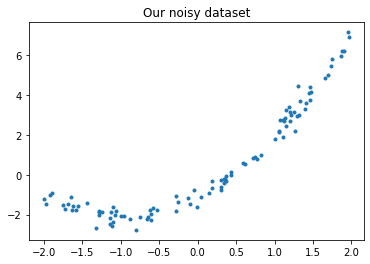

In [19]:
import matplotlib.pyplot as plt

plt.title('Our noisy dataset')
plt.plot(XX, YY, '.')
plt.show()

Now we are ready to estimate the values of our parameters, using only the observed samples, and the knowledge that the model we are seeking is a 2 degree polynomial.

First of all, we will define three variables for our weights that we will initialise to some value - you can try to change the initialisation value to check that it has no effect in the final result.

We will eventually want to calculate the derivatives of the error with respect to each of these weights, so that we can apply gradient descent. Therefore, these variables require gradient calculation as well.

In [25]:
# Create variables for our parameters (weights), and initialise them all to 1.0
w0 = Variable(0.0, requiresGrad = True)
w1 = Variable(0.0, requiresGrad = True)
w2 = Variable(0.0, requiresGrad = True)

Next, we do a bit of housekeeping. We define the learning rate that we will use (feel free to change it and see what happens), as well as an empty list in which we will be keeping track of the training loss as it evolves during our training.

*Note that we use "loss" and "cost" quite interchangably in these notebooks - the correct way to use it would be to call loss just the individual error for a single sample, and cost the aggregated error over the whole batch. In practice you will see these names used quite interchangably by different authors, and you should be able to tell what they refer to every time you see them.*

In [21]:
lr = 0.01 # Our learning rate
training_loss = []

Now we will define our typical training loop to implement gradient descent.

During each epoch we process the whole batch of data we have, and we will do 2000 epochs (feel free to change this and see what happens).

Within each epoch, we will take each sample in our dataset and do a forward pass - calculate the polynomial, using our current values for the weights. The result `out` is our estimated output for the sample. We will then compare it with the true value for the sample (the noisy value we have observed). Here we will use a Mean Square Error cost, so our loss is just the square distance between the estimated and the true (observed) value.

We will accumulate the loss for all samples into the `batch_loss` variable, and at the end of each epoch we will divide by the number of samples to get the average error.

This is the value that we will backpropagate. This will update the gradient information of all our variables that require gradients, all the way back to the three weights. These gradients are then used to update the weights using simple gradient descent.

### <font color=blue>Excercise 2:</font>
    
<font color=blue> Notice that our autograd engine is missing some operations that are required in the forward pass for our regression problem.

- Add these functionalities to our autograd engine
- Allow our engine to work with both Variables and constants so that we dont have to create variables for everything. </font>

In [22]:
def vAdd(A: Variable, B: Variable):
    if not isinstance(A, Variable):
      A = Variable(A)
    if not isinstance(B, Variable):
      B = Variable(B)
    result = Variable(A.value + B.value) # Create a new Variable to store the result, and pass it the value = a + b
          
    #keep track of the parent variables, and of the local derivative associated with each one
    result.gradRoutes.append((A, 1)) # dresult / dA = 1
    result.gradRoutes.append((B, 1)) # dresult / dB = 1
    
    return result

def vSub(A: Variable, B: Variable):
    if not isinstance(A, Variable):
      A = Variable(A)
    if not isinstance(B, Variable):
      B = Variable(B)
    result = Variable(A.value - B.value) # Create a new Variable to store the result, and pass it the value = a + b
          
    #keep track of the parent variables, and of the local derivative associated with each one
    result.gradRoutes.append((A, 1)) # dresult / dA = 1
    result.gradRoutes.append((B, -1)) # dresult / dB = 1
    
    return result
    
def vMul(A: Variable, B: Variable):
    if not isinstance(A, Variable):
      A = Variable(A)
    if not isinstance(B, Variable):
      B = Variable(B)
    result = Variable(A.value * B.value) # Create a new Variable to store the result, and pass it the value = a + b
          
    #keep track of the parent variables, and of the local derivative associated with each one
    result.gradRoutes.append((A, B.value)) # dresult / dA = B
    result.gradRoutes.append((B, A.value)) # dresult / dB = A
    
    return result

def vDiv(A: Variable, B: Variable):
    if not isinstance(A, Variable):
      A = Variable(A)
    if not isinstance(B, Variable):
      B = Variable(B)
    result = Variable(A.value / B.value) # Create a new Variable to store the result, and pass it the value = a + b
          
    #keep track of the parent variables, and of the local derivative associated with each one
    result.gradRoutes.append((A, 1/B.value)) # dresult / dA = B
    result.gradRoutes.append((B, -1*A.value*B.value**(-1/B.value**2)))
    
    return result

def vPow(A: Variable, B: Variable):
    if not isinstance(A, Variable):
      A = Variable(A)
    if not isinstance(B, Variable):
      B = Variable(B)
    result = Variable(A.value ** B.value) # Create a new Variable to store the result, and pass it the value = a + b
          
    #keep track of the parent variables, and of the local derivative associated with each one
    result.gradRoutes.append((A, B.value*A.value**(B.value-1)))
    
    return result

In [23]:
# Your Code Here
class Variable: #Simple variable. These are the leafs of our tree, they can request to have a gradient calculated, or not
    def __init__(self, value, requiresGrad=True):
        self.value = value
        self.gradRoutes = [] # A variable by default has no grad Routes (was not created by anything, just defined)
        self.grad = 0.0
        self.requiresGrad = requiresGrad
    
    def backProp(self, route_val = 1.0):
        # Add together the incoming gradients from the different routes that lead to a node - this will be the final gradient for the node
        self.grad += route_val
                
        # For every parent variable and corresponding local derivative value that we have in the gradRoutes, continue with the gradient calculation
        for variable, local_derivative_value in self.gradRoutes:
              if variable.requiresGrad == True:
                # Multiply the incoming gradient with the local derivatives corresponding the parent variable, and continue the backpropagation
                variable.backProp(local_derivative_value * route_val)

    def zeroGrad(self):
        self.grad = 0.0
        
    def zeroGradsRecursively(self):
        self.zeroGrad()
        for variable, _ in self.gradRoutes:
            variable.zeroGradsRecursively()
            
    def __add__(self, b):
        return vAdd(self, b)

    def __sub__(self, b):
        return vSub(self, b)
        
    def __mul__(self, b):
        return vMul(self, b)    

    def __truediv__(self, b):
        return vDiv(self, b)  

    def __pow__(self, b):
        return vPow(self, b)     
    
    def __str__(self):
        return 'Value: {self.value}, Gradient: {self.grad}'.format(self=self)

In [26]:
import time

t = time.time() # Keep track of the time we started

for epoch in range(2000):

    #Zero gradients
    w0.zeroGrad()
    w1.zeroGrad()
    w2.zeroGrad()
    
    batch_loss = Variable(0.0)
    for x, y in zip(XX, YY):
        #Forward pass
        out = w0 + w1 * x + w2 * (x**2)
        
        # calculate loss for this training sample
        loss = (out - y)**2
        
        # accumulate losses
        batch_loss += loss
        

    # calculate cost (average of the individual losses)
    batch_loss /= m
    training_loss.append(batch_loss.value) # keep track of how our training loss evolves
    
    #backpropagate
    batch_loss.backProp()

    #Update parameters
    w0.value = w0.value - lr * w0.grad
    w1.value = w1.value - lr * w1.grad
    w2.value = w2.value - lr * w2.grad    

    del batch_loss # this should free some resources

# Check how long it took
print("Training took (secs):", time.time() - t)

Training took (secs): 6.1133034229278564


So, that took a while. Let's see what values we estimated.

Estimated weights: -1.1042269136150724 2.029129710839384 1.0336235467558479


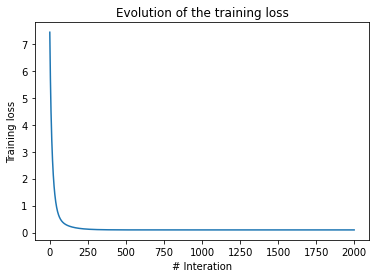

In [27]:
# Print our our results
print("Estimated weights:", w0.value, w1.value, w2.value)

#Make a plot of the evolution of the training loss
plt.title('Evolution of the training loss')
plt.xlabel("# Interation")
plt.ylabel("Training loss")
plt.plot(training_loss)
plt.show()

The estimated values are not very far off the real values we used in the beginning. This is good news. Let's also plot the estimated polynomial to double check.

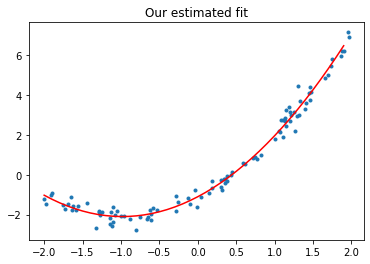

In [28]:
# Plot the result
plt.title('Our estimated fit')
plt.plot(XX, YY, '.')

x = np.arange(-2, 2, 0.1)
y = w0.value + w1.value * x + w2.value * x**2
plt.plot(x, y, 'r')

Note that the code above is VERY inefficient, but it should be readable.



### <font color=blue>Excercise 3:</font>


<font color=blue> A) Can you draw the computation graph we have created here.</font>

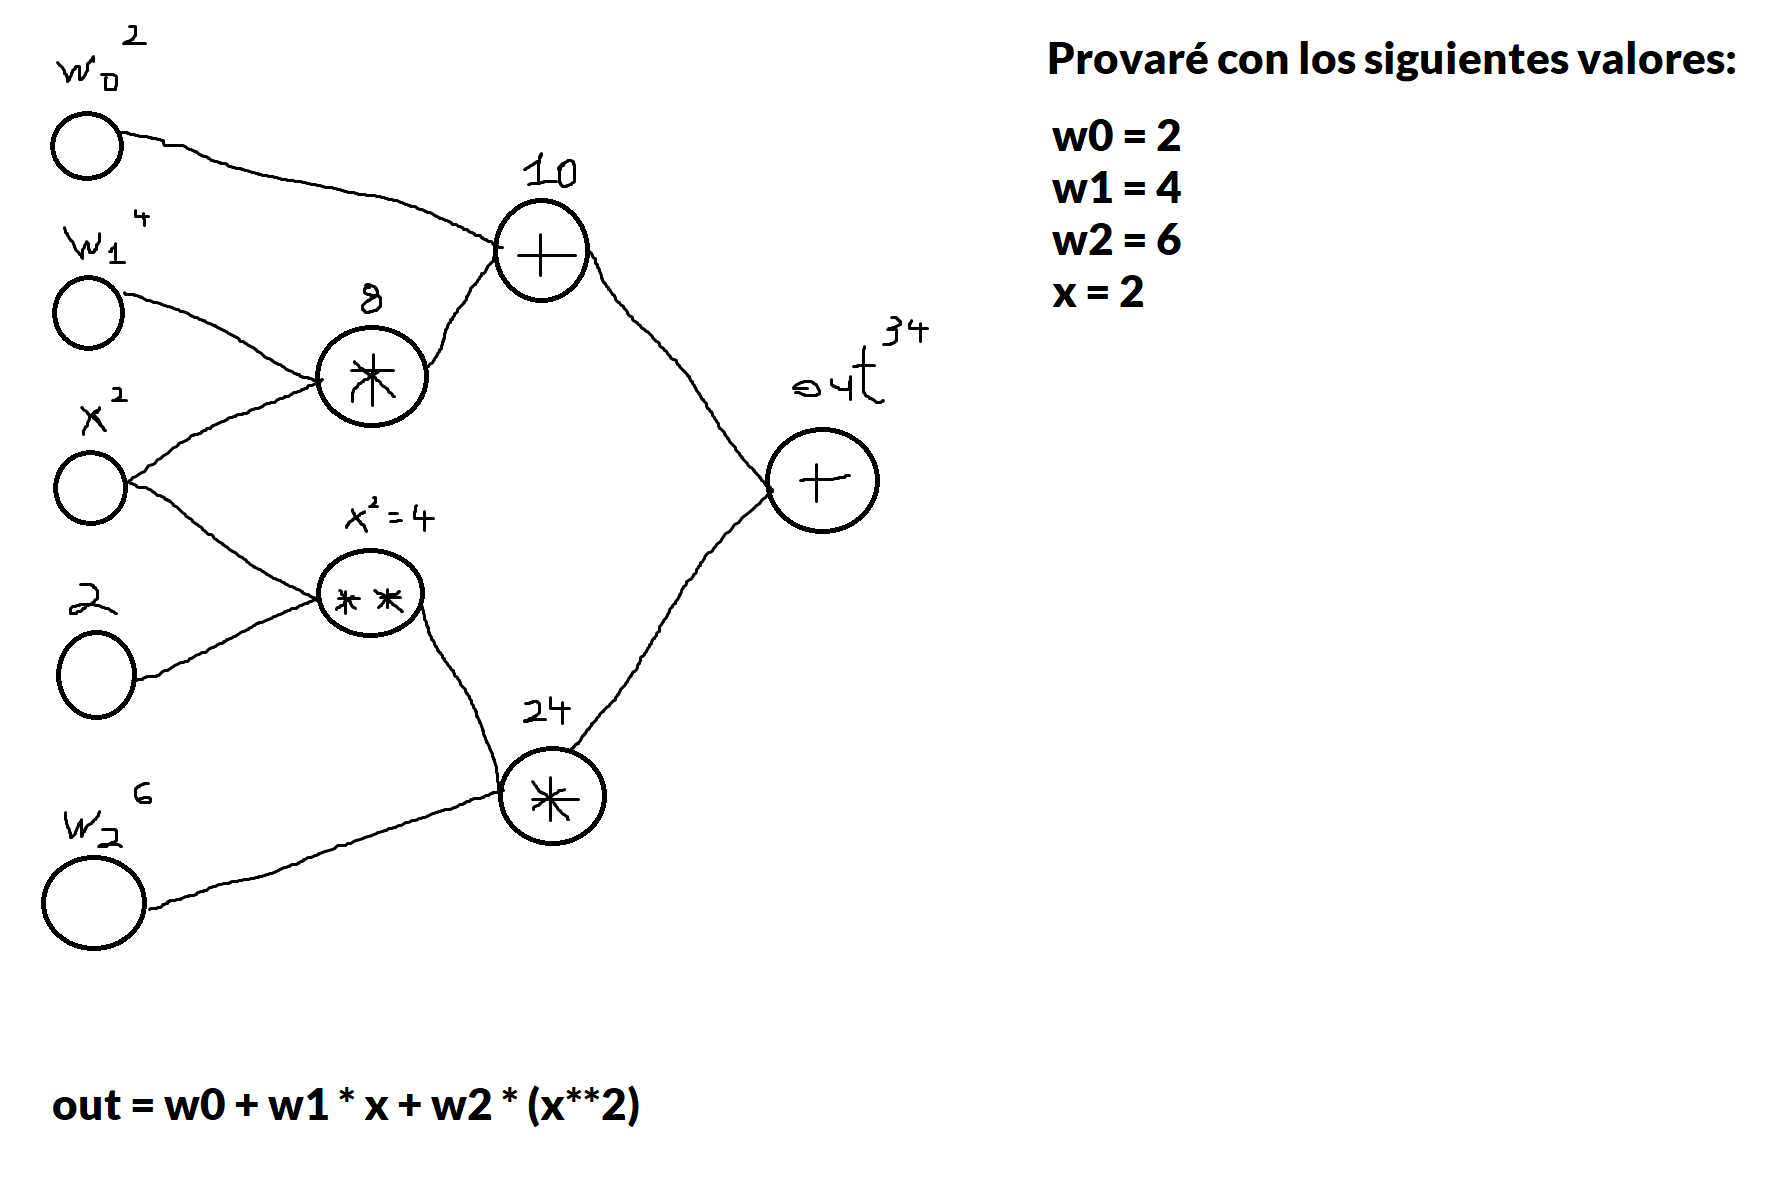

<font color=blue> B) Can we make this training loop more efficient in any way? How?</font>

Para hacer el loop más eficiente debemos evitar el hecho de estar creando un grafo nuevo por cada x que tenemos, ya que esto es ineficiente en memoria. Aunque he probado de resolver este problema durante mucho rato, no he conseguido ninguna solución que funcione.

## Classification

Now that we have seen how this works for regression, let's apply the same approach to a simple classification problem.

First, we will create some random data for two concentric classes. The decision boundary between the two classes will be a circle.

In [31]:
m_per_class = 50
m= 2 * m_per_class
w = [2.0, 1.0, 3.0] # corresponding to radius and center of a circular decision boundary

#Class 1 - random points inside the decision boundary
angle = 2.0 * np.pi * np.random.rand(m_per_class)
radius = w[0] * np.random.rand(m_per_class) #Radius in [0, w0]

XX1 = w[1] + radius * np.cos(angle)
XX2 = w[2] + radius * np.sin(angle)
labels = np.zeros(m_per_class)

#Class 2 - random points outside the decision boundary
angle = 2.0 * np.pi * np.random.rand(m_per_class)
radius = w[0] +  w[0] * np.random.rand(m_per_class) #Radius in [w0, 2 * w0]

XX1 = np.concatenate( (XX1, w[1] + radius * np.cos(angle)) )
XX2 = np.concatenate( (XX2, w[2] + radius * np.sin(angle)) )
labels = np.concatenate( (labels, np.ones(m_per_class)) )

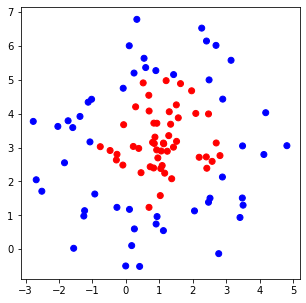

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize = (5, 5))
plt.scatter(XX1, XX2, c = [('red' if cl == 0 else 'blue') for cl in labels])

Since we have our own AutoGrad framework, instead of handcrafting features we will try to solve this directly, assuming the equation of a circle with unknown centre and radius. Our AutoGrad framework will figure out the gradients for whatever equation we give it.

### <font color=blue>Excercise 4:</font>


<font color=blue> Adapt the solution for the regression problem we saw before to this scenario. This would imply changing the equation for the forward pass to the equation of a circle + sigmoid activation, and also changing the loss to a cross entropy one. Update the autograd framework as you see fit, in case you need to use operations you do not have.</font>

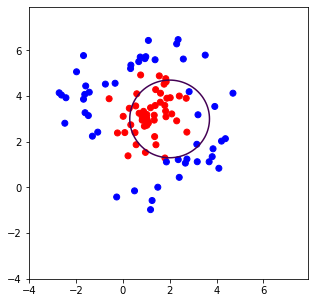

In [ ]:
# Your code here


In [ ]:
plt.figure(figsize = (5, 5))

plt.scatter(XX1, XX2, c = [('red' if cl == 0 else 'blue') for cl in labels])

x = y = np.arange(-4, 8, 0.1)
xx, yy = np.meshgrid(x, y, sparse=True)
z = ( ((xx-w1.value)**2) + ((yy-w2.value)**2) )**0.5 - w0.value
h = plt.contour(x,y,z, levels = [0.5])